In [1]:
# Parameters
system_name = "J1620+1203"
filter = "F160W"
use_psf_variance_map = True
r1 = 4.2
dx_outer = 0.4
dy_outer = 0.35
dx_center = 0.2
dy_center = 0.1
x1 = 40
y1 = 41
x2 = 44
y2 = 46
x3 = 67
y3 = 65
use_center_mask = False
r1_f814w = 3.5
dx_outer_f814w = 0.3
dy_outer_f814w = 0.2
lens_center_x_f814w = 85
lens_center_y_f814w = 93
r1_f475x = 3.5
dx_outer_f475x = 0.3
dy_outer_f475x = 0.2
lens_center_x_f475x = 85
lens_center_y_f475x = 93

In [2]:
# Standard Python imports
import os
import copy
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Astropy imports
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, LogStretch
import astropy.io.fits as pyfits

# Lenstronomy imports
import lenstronomy
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Data.psf import PSF
from lenstronomy.Util import kernel_util
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util, util

## Redirect MCMC output to .txt file to not clutter the notebook later on

In [3]:
import sys
import os
import contextlib

@contextlib.contextmanager
def suppress_stdout_stderr(to_file):
    """
    Redirect stdout and stderr to a file.
    """
    with open(to_file, 'w') as f:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = f
        sys.stderr = f
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Create Masking Function

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def create_central_mask(kwargs_data, x_coords, y_coords,
                        lens_center_x, lens_center_y,
                        r_outer=4.0,
                        dx_outer=0.0, dy_outer=0.0,
                        use_center_mask=False,
                        dx_center=0.2, dy_center=0.1,
                        a_center=0.6, b_center=0.6, phi_center=0.0,
                        plot=True):
    """
    Create a central mask before modeling.

    Parameters
    ----------
    kwargs_data : dict
        Dictionary containing "image_data".
    x_coords, y_coords : array
        Coordinate grids (pixel coordinates).
    lens_center_x, lens_center_y : float
        Lens center coordinates (RA/DEC in arcseconds).
    r_outer : float
        Radius of the outer circular mask (arcsec).
    dx_outer, dy_outer : float
        Offsets for the outer mask.
    use_center_mask : bool
        Whether to apply an additional central ellipse mask.
    dx_center, dy_center : float
        Offsets for the central ellipse mask.
    a_center, b_center : float
        Semi-major and semi-minor axes of the central mask.
    phi_center : float
        Rotation angle (radians).
    plot : bool
        Whether to plot the results.

    Returns
    -------
    mask_img : 2D array
        Final mask array (1 = keep, 0 = masked).
    image_masked : 2D array
        Log-scaled image after masking.
    """

    num_pix = len(kwargs_data["image_data"])

    # Outer circular mask
    mask_outer = mask_util.mask_center_2d(
        lens_center_x + dx_outer,
        lens_center_y + dy_outer,
        r_outer,
        util.image2array(x_coords),
        util.image2array(y_coords),
    )
    mask = 1 - mask_outer

    # Optional central elliptical mask
    if use_center_mask:
        mask_center = mask_util.mask_ellipse(
            util.image2array(x_coords),
            util.image2array(y_coords),
            lens_center_x + dx_center,
            lens_center_y + dy_center,
            a_center,
            b_center,
            phi_center,
        )
        mask *= (1 - mask_center)

    # Ensure binary mask
    mask[mask >= 1] = 1
    mask[mask < 0] = 0

    # Reshape to image grid
    mask_img = mask.reshape(num_pix, num_pix)

    # Apply to image
    image_masked = np.log10(kwargs_data["image_data"] * mask_img)

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(15, 10))
        axs[0].imshow(mask_img, origin="lower")
        axs[0].set_title("MASKING")

        axs[1].imshow(image_masked, origin="lower", cmap="cubehelix")
        axs[1].set_title("IMAGE AFTER MASKING")
        plt.show()

    return mask_img, image_masked

# Prepare F814W Data

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_9645/402528142.py:22: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


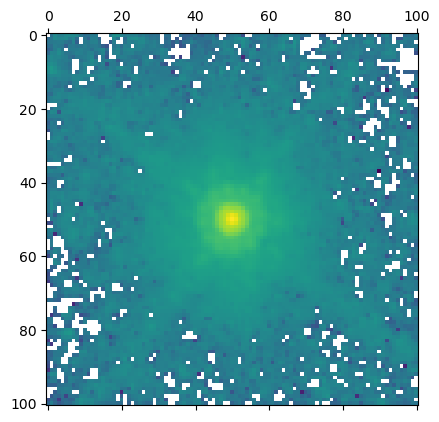

In [5]:
# load F814W PSF data
psf_file = f'cutout_data/{system_name}/F814W/outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf1 = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3, 
              }

if use_psf_variance_map == True:
    variance = np.loadtxt(f'cutout_data/{system_name}/F814W/psf_variance.txt')
    var_array = np.array(variance)
    kwargs_psf1.update({'psf_variance_map': var_array})
    
psf_class = PSF(**kwargs_psf1)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

In [6]:
# Open the FITS file and extract the header
filename = f'joint_modeling/{system_name}/{system_name}_F814W_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

deltaPix = 0.04  # size of UVIS pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

# set up data class
kwargs_data1 = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

kwargs_numerics1 = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_9645/2316528304.py:4: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')


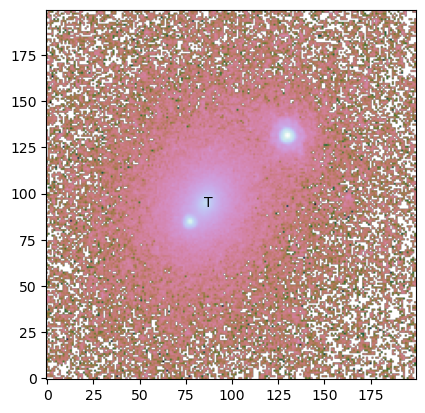

In [7]:
# display science image and obtain coordinates of lens center
plt.annotate('T', [lens_center_x_f814w, lens_center_y_f814w], color='black')

plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')


lens_pos = pixel_grid.map_pix2coord(lens_center_x_f814w, lens_center_y_f814w)

# lens coordinates
lens_center_x, lens_center_y = lens_pos[0], lens_pos[1]

plt.show()

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_9645/4202579364.py:79: RuntimeWarning: divide by zero encountered in log10
  image_masked = np.log10(kwargs_data["image_data"] * mask_img)
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_9645/4202579364.py:79: RuntimeWarning: invalid value encountered in log10
  image_masked = np.log10(kwargs_data["image_data"] * mask_img)


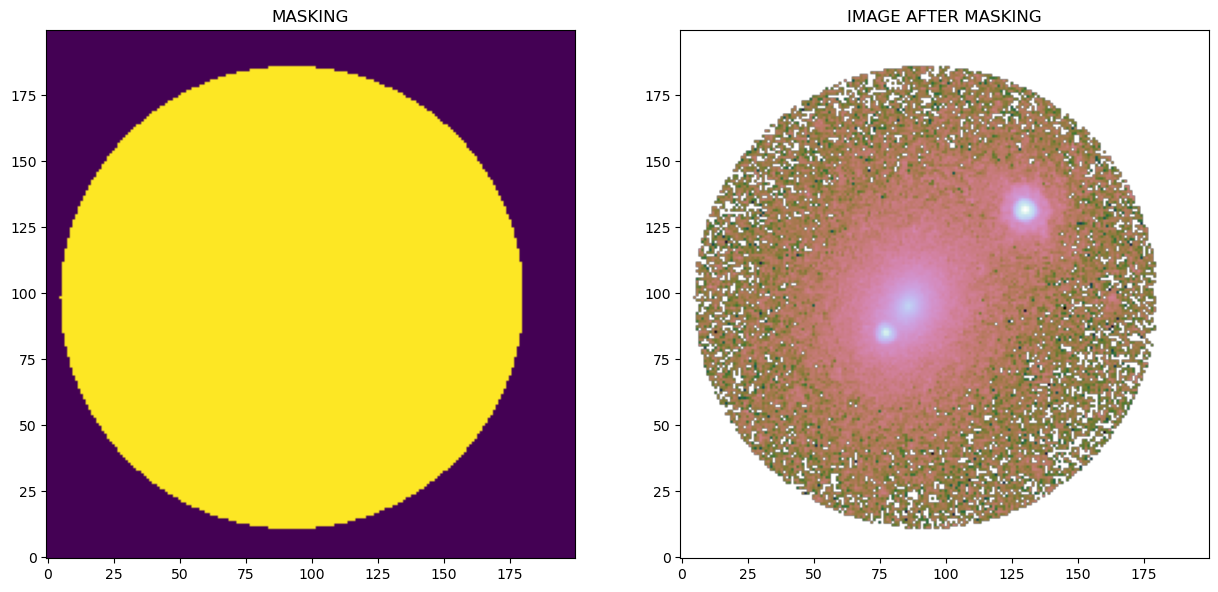

In [8]:
mask_data1, _ = create_central_mask(kwargs_data1, x_coords, y_coords, lens_center_x, lens_center_y,
                                   r1_f814w, dx_outer_f814w, dy_outer_f814w)

# Prepare F475X Data

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_9645/477278475.py:20: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


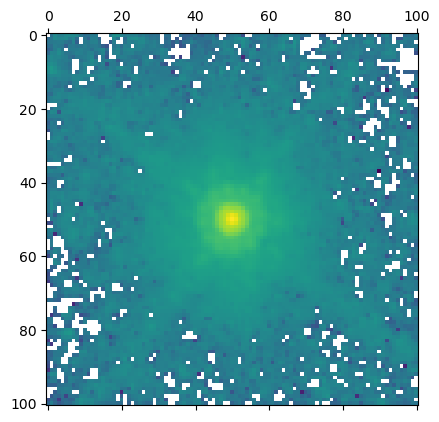

In [9]:
# load F475X PSF data
psf_file = f'cutout_data/{system_name}/F475X/outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf2 = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3, 
              }

if use_psf_variance_map == True:
    variance = np.loadtxt(f'cutout_data/{system_name}/F475X/psf_variance.txt')
    var_array = np.array(variance)
    kwargs_psf2.update({'psf_variance_map': var_array})
    
kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

In [10]:
# Open the FITS file and extract the header
filename = f'joint_modeling/{system_name}/{system_name}_F475X_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

# import the PixelGrid() class #

deltaPix = 0.04  # size of UVIS pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

# set up data class
kwargs_data2 = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

kwargs_numerics2 = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_9645/259183908.py:4: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')


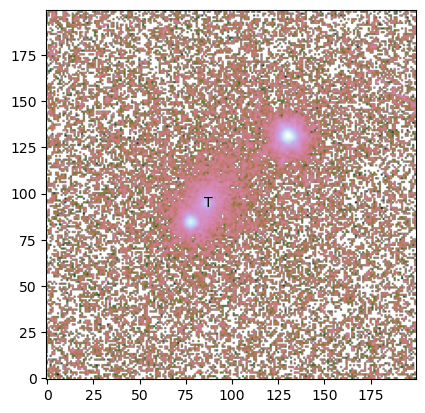

In [11]:
# display science image and obtain coordinates of lens center
plt.annotate('T', [lens_center_x_f475x, lens_center_y_f475x], color='black')

plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')

lens_pos = pixel_grid.map_pix2coord(lens_center_x_f475x, lens_center_y_f475x)

# lens coordinates
lens_center_x, lens_center_y = lens_pos[0], lens_pos[1]

plt.show()

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_9645/4202579364.py:79: RuntimeWarning: divide by zero encountered in log10
  image_masked = np.log10(kwargs_data["image_data"] * mask_img)
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_9645/4202579364.py:79: RuntimeWarning: invalid value encountered in log10
  image_masked = np.log10(kwargs_data["image_data"] * mask_img)


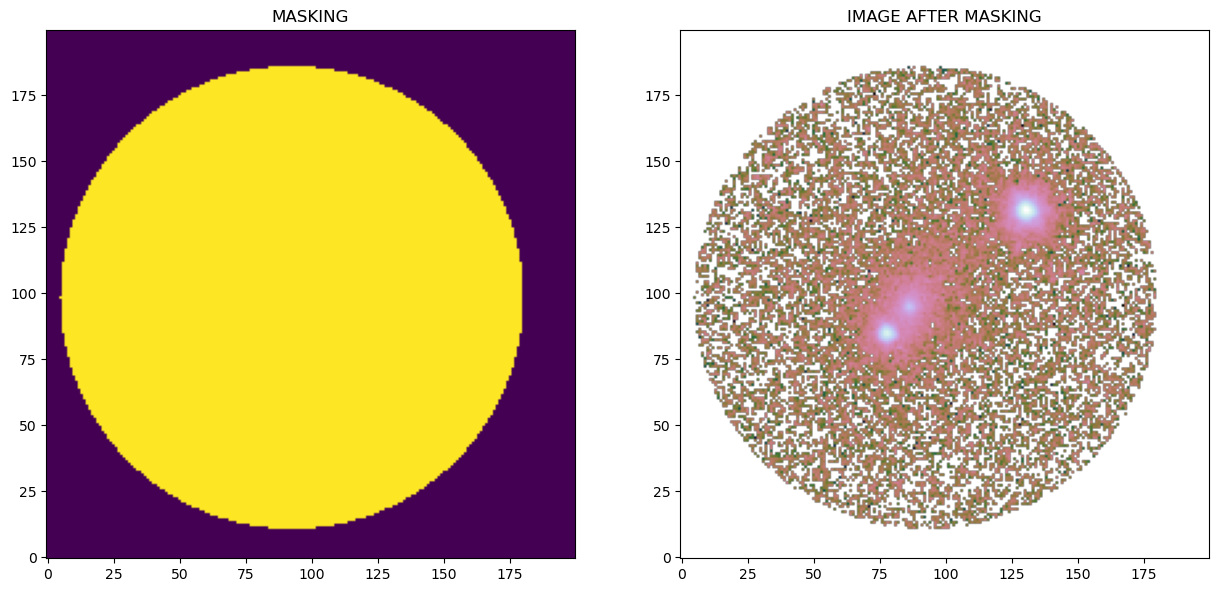

In [12]:
mask_data2, _ = create_central_mask(kwargs_data2, x_coords, y_coords, lens_center_x, lens_center_y,
                                   r1_f475x, dx_outer_f475x, dy_outer_f475x)

# Prepare F160W Data

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_9645/327559786.py:22: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


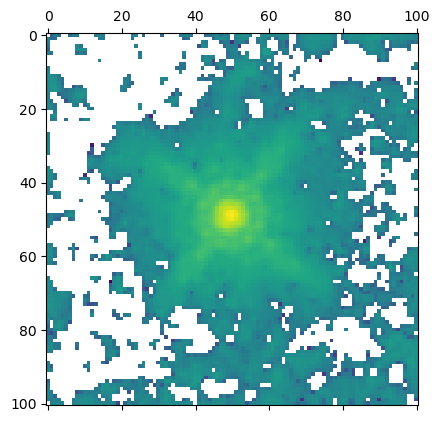

In [13]:
# load F475X PSF data
psf_file = f'cutout_data/{system_name}/F160W/outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf3 = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3, 
              }

if use_psf_variance_map == True:
    variance = np.loadtxt(f'cutout_data/{system_name}/F160W/psf_variance.txt')
    var_array = np.array(variance)
    kwargs_psf3.update({'psf_variance_map': var_array})
    
psf_class = PSF(**kwargs_psf3)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_9645/373875719.py:63: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')


Initial guess for theta_E: 1.4449913494550755


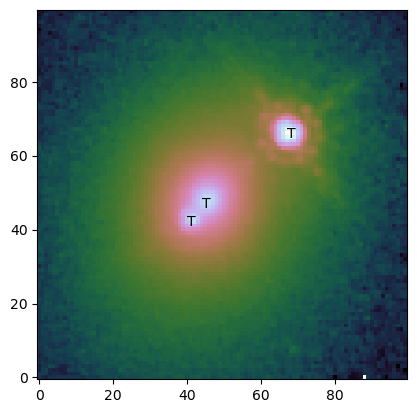

In [14]:
# Open the FITS file and extract the header
filename = f'cutout_data/{system_name}/F160W/{system_name}_F160W_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

# import the PixelGrid() class #

deltaPix = 0.08  # size of IR pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

# set up data class
kwargs_data3 = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

kwargs_numerics3 = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}

# display science image and obtain coordinates of point source and lens centers
plt.annotate('T', [x1,y1], color='black')
plt.annotate('T', [x2,y2], color='black')
plt.annotate('T', [x3,y3], color='black')

plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')

im1 = pixel_grid.map_pix2coord(x1, y1)

lens_pos = pixel_grid.map_pix2coord(x2,y2)

im2 = pixel_grid.map_pix2coord(x3,y3)

# lens coordinates
lens_center_x, lens_center_y = lens_pos[0], lens_pos[1]
# image coordinates #
im1_x, im1_y = im1[0], im1[1]
im2_x, im2_y = im2[0], im2[1]

# calculate the initial guess for theta_E as half the image separation
einstein_rad = np.sqrt((im2_x - im1_x)**2 + (im2_y - im1_y)**2) / 2
print(f'Initial guess for theta_E: {einstein_rad}')

# set up point source and lens positions
theta_ra = np.array([im1_x, im2_x])
theta_dec = np.array([im1_y, im2_y])

plt.show()

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_9645/4202579364.py:79: RuntimeWarning: divide by zero encountered in log10
  image_masked = np.log10(kwargs_data["image_data"] * mask_img)


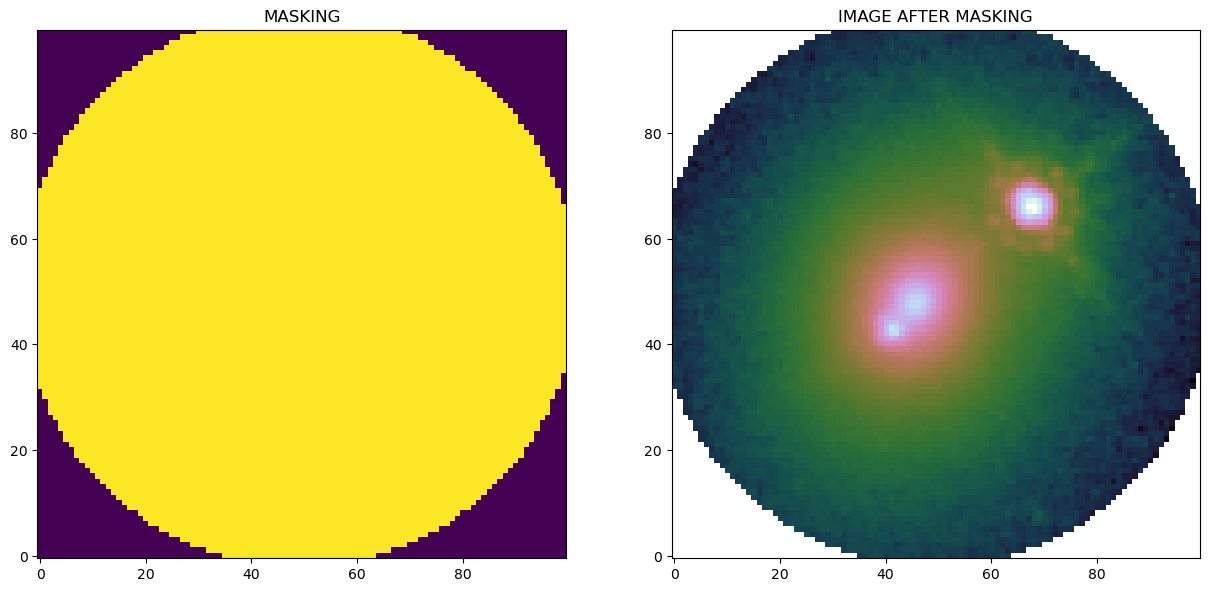

In [15]:
mask_data3, _ = create_central_mask(kwargs_data3, x_coords, y_coords, lens_center_x, lens_center_y,
                                   r1, dx_outer, dy_outer)

In [16]:
# model parameters, applicaple for both bands

lens_model_list = ['EPL', 'SHEAR']

lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
                         #'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
index_lens_light_model_list = [[0], [1], [2]]

source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
index_source_light_model_list = [[0], [1], [2]]

point_source_list = ['LENSED_POSITION']

# set up model arguments

kwargs_model = {'lens_model_list': lens_model_list,
                               'lens_light_model_list': lens_light_model_list,
                               'index_lens_light_model_list': index_lens_light_model_list,
                               'point_source_model_list': point_source_list,
                               #'source_light_model_list': source_model_list
                               }


kwargs_constraints = {
    'num_point_source_list': [2],
    'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]],
    'joint_lens_light_with_lens_light': [
        [0, 1, ['center_x', 'center_y']],
        [0, 2, ['center_x', 'center_y']],
        #[2, 3, ['center_x', 'center_y']],
        #[0, 4, ['center_x', 'center_y']],
        #[4, 5, ['center_x', 'center_y']],
    ],
    # 'joint_source_with_point_source': [[0, 0]],
}

kwargs_likelihood = {'check_bounds': True,
                     'image_likelihood_mask_list': [mask_data3, mask_data1, mask_data2],
                            #'image_position_uncertainty': 0.004,
                      'source_position_likelihood': True,                              
                      'source_position_tolerance': 0.001
                              }

image_band1 = [kwargs_data1, kwargs_psf1, kwargs_numerics1]
image_band2 = [kwargs_data2, kwargs_psf2, kwargs_numerics2]
image_band3 = [kwargs_data3, kwargs_psf3, kwargs_numerics3]
multi_band_list = [image_band3, image_band1, image_band2]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [17]:
# initial guess of non-linear parameters
kwargs_lens_init = [{'theta_E': einstein_rad, 'gamma': 2., 'e1': 0., 'e2': 0., 'center_x': lens_center_x, 'center_y': lens_center_y},
                    {'gamma1': 0., 'gamma2': 0., 'ra_0': 0, 'dec_0': 0}]
kwargs_lens_light_init = [{'R_sersic': 1., 'n_sersic': 2., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y},
                          {'R_sersic': 2., 'n_sersic': 4., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y}]

kwargs_source_init = [{'R_sersic': 0.3, 'n_sersic': 1., 'e1': 0., 'e2': 0., 'center_x': lens_center_x, 'center_y': lens_center_y}]
kwargs_ps_init = [{'ra_image': theta_ra, 'dec_image': theta_dec}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.2, 'gamma': .5, 'e1': .5, 'e2': .5, 'center_x': 0.1, 'center_y': 0.1},
                     {'gamma1': .1, 'gamma2': .1}]
kwargs_lens_light_sigma = [{'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1},
                           {'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1}]
kwargs_source_sigma = [{'R_sersic': .5, 'n_sersic': .5, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': .1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 2, 'dec_image': [0.02] * 2}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0.01, 'gamma': 1., 'e1': -0.15, 'e2': -0.15, 'center_x': -10., 'center_y': -10},
                     {'gamma1': -0.3, 'gamma2': -0.3}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10},
                           {'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.15, 'e2': -0.15, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(theta_ra), 'dec_image': -10 * np.ones_like(theta_dec)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'gamma': 3., 'e1': 0.15, 'e2': 0.15, 'center_x': 10., 'center_y': 10},
                     {'gamma1': 0.3, 'gamma2': 0.3}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 6., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10},
                           {'R_sersic': 10, 'n_sersic': 6., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10}]
kwargs_upper_source = [{'R_sersic': 1.5, 'n_sersic': 1.5, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(theta_ra), 'dec_image': 10 * np.ones_like(theta_dec)}]


kwargs_lens_light_init.extend([{'R_sersic': 1., 'n_sersic': 2., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y},
                          #{'R_sersic': 2., 'n_sersic': 4., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y},
                          #{'R_sersic': 1., 'n_sersic': 2., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y},
                          #{'R_sersic': 2., 'n_sersic': 4., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y}
                          ])
                    
kwargs_lens_light_sigma.extend([{'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1},
                           #{'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1},
                           #{'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1},
                           #{'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1}
                           ])

kwargs_lower_lens_light.extend([{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10},
                           #{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10},
                           #{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10},
                           #{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10}
                           ])

kwargs_upper_lens_light.extend([{'R_sersic': 10, 'n_sersic': 6., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10},
                           #{'R_sersic': 10, 'n_sersic': 6., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10},
                           #{'R_sersic': 10, 'n_sersic': 6., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10},
                           #{'R_sersic': 10, 'n_sersic': 6., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10}
                           ])


kwargs_source_init.extend([{'R_sersic': 0.3, 'n_sersic': 1., 'e1': 0., 'e2': 0., 'center_x': lens_center_x, 'center_y': lens_center_y},
                           {'R_sersic': 0.3, 'n_sersic': 1., 'e1': 0., 'e2': 0., 'center_x': lens_center_x, 'center_y': lens_center_y}])

kwargs_source_sigma.extend([{'R_sersic': .5, 'n_sersic': .5, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': .1},
                            {'R_sersic': .5, 'n_sersic': .5, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': .1}])

kwargs_lower_source.extend([{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.15, 'e2': -0.15, 'center_x': -10, 'center_y': -10},
                            {'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.15, 'e2': -0.15, 'center_x': -10, 'center_y': -10}])

kwargs_upper_source.extend([{'R_sersic': 1.5, 'n_sersic': 1.5, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10},
                            {'R_sersic': 1.5, 'n_sersic': 1.5, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}])

lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}, {}, {}], kwargs_lower_lens_light, kwargs_upper_lens_light]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}, {}, {}], kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                 #'source_model': source_light_params_list,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/LensModel/Profiles/epl.py:297: RuntimeWarning: invalid value encountered in divide
  R_omega = Z * hyp2f1(1, t / 2, 2 - t / 2, -(1 - q) / (1 + q) * (Z / Z.conj()))


Computing the PSO ...


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:224: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1218: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


Max iteration reached! Stopping.
-2.240425134255318 reduced X^2 of best position
-9418.747264409358 log likelihood
8408.0 effective number of data points
[{'theta_E': np.float64(1.5531651636980752), 'gamma': 2, 'e1': np.float64(-0.10464687110090602), 'e2': np.float64(-0.02466928931782138), 'center_x': np.float64(7.662726532062226), 'center_y': np.float64(-0.10183491328284416)}, {'gamma1': np.float64(0.0394723160116169), 'gamma2': np.float64(-0.06025140669256577), 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': np.float64(2.177921407472755), 'n_sersic': np.float64(5.650915303512379), 'e1': np.float64(-0.0747791555847915), 'e2': np.float64(0.1002025240577668), 'center_x': np.float64(7.662726532062226), 'center_y': np.float64(-0.10183491328284416)}, {'amp': 1, 'R_sersic': np.float64(1.5611653464163815), 'n_sersic': np.float64(3.742747887780762), 'e1': np.float64(-0.040750270976103814), 'e2': np.float64(-0.0032156357229002615), 'center_x': np.float64(7.66272653

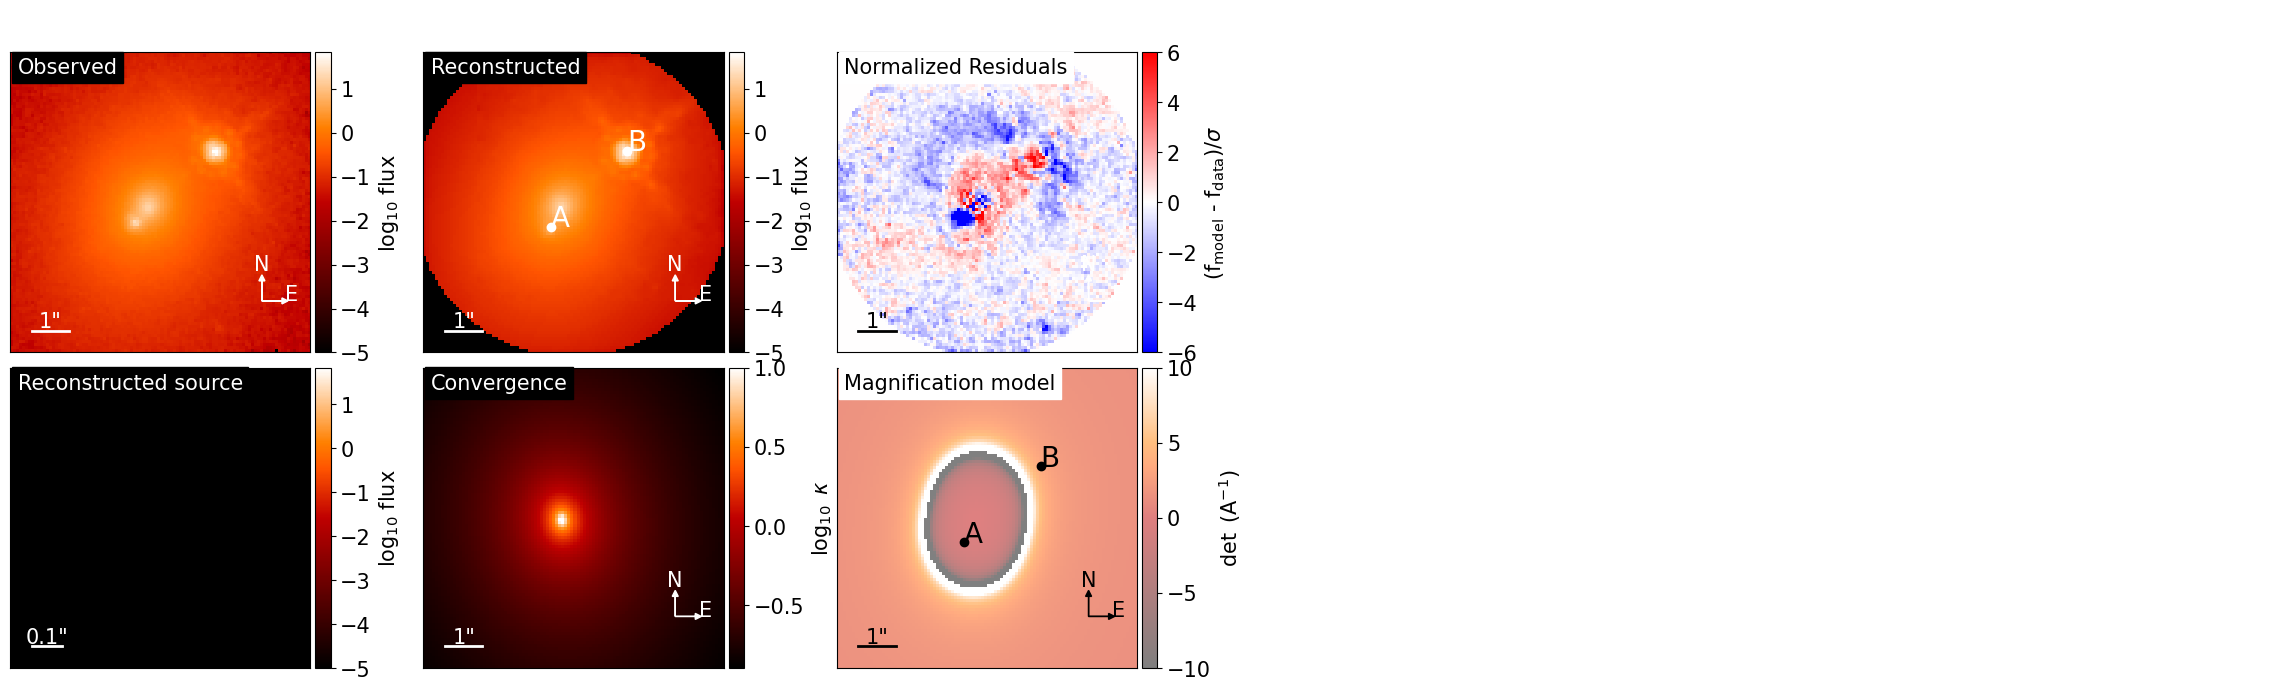

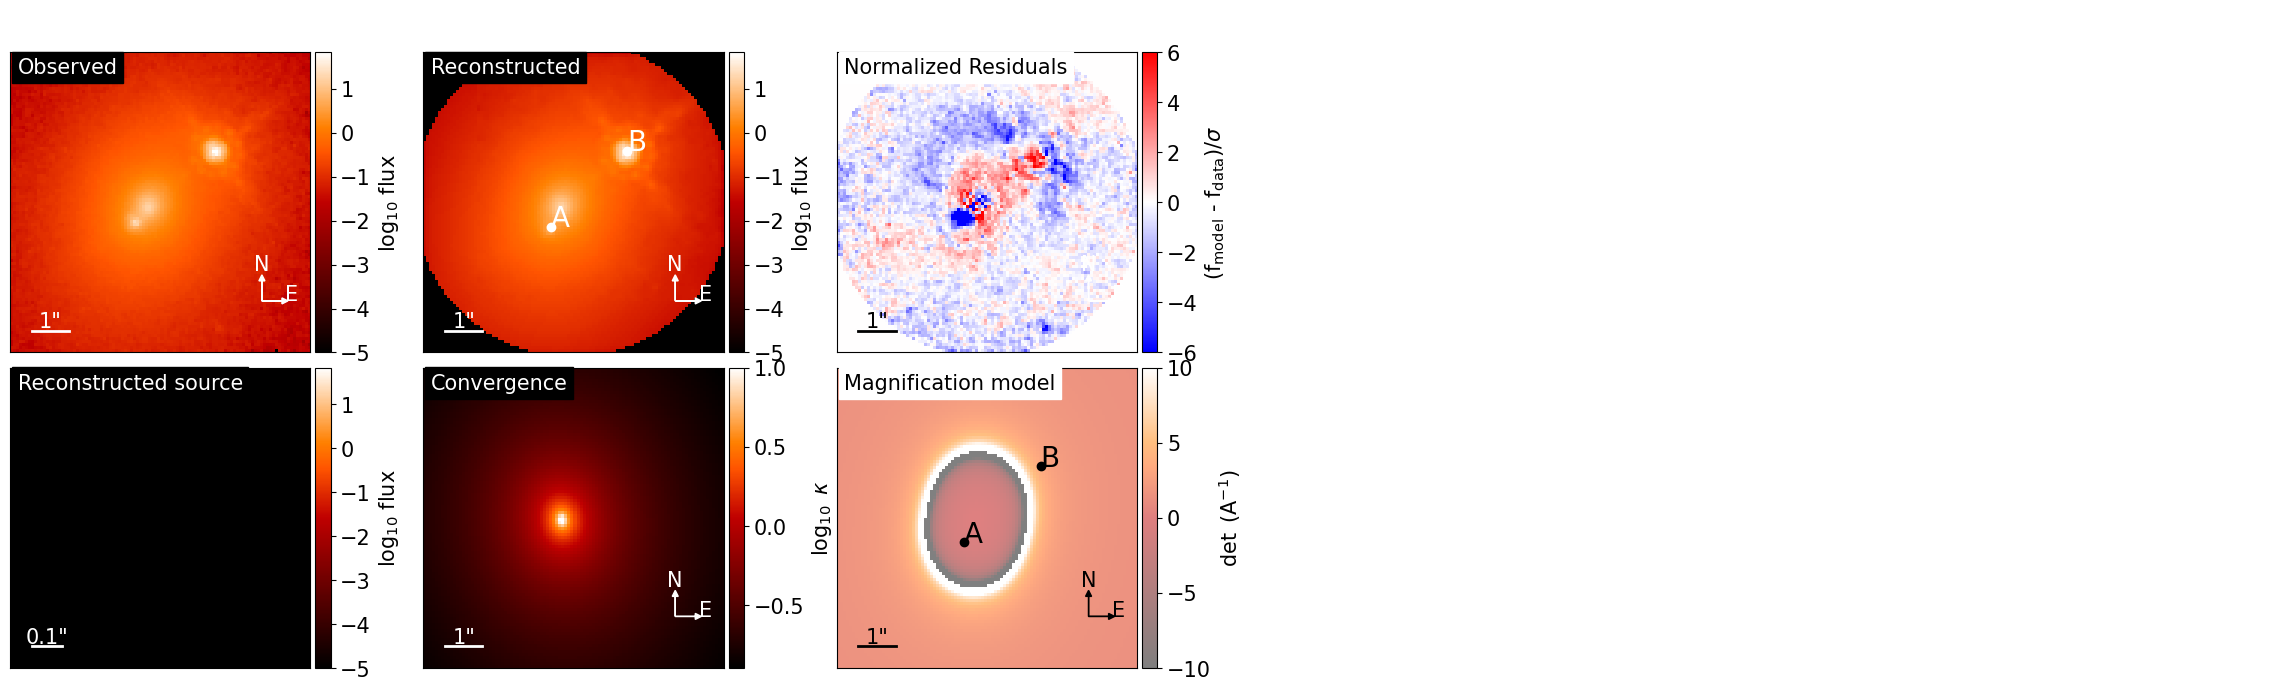

In [18]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, verbose = True)

fitting_kwargs_list = [
    ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, False, False]}}], 
    ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],  # run PSO first band
    ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

filter_index = 0
single_band = [multi_band_list[filter_index]]

# Create ModelPlot with single-band list
modelPlot = ModelPlot(single_band, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")

# Plot
f, axes = modelPlot.plot_main()
f

In [19]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
kwargs_psf_iter = {'stacking_method': 'median', 
                    'psf_symmetry': 4, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 100, 
                    'psf_iter_factor': 0.2,
                    'compute_bands': [True, False, False]
                      }

if use_psf_variance_map ==  True:
    kwargs_psf_iter.update({'keep_psf_variance_map': True})

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

new_multiband = fitting_seq.multi_band_list
kwargs_result = fitting_seq.best_fit()
kwargs_psf_updated = multi_band_list[0][1]

iteration of step 0 gave best reconstruction.
log likelihood before: -9418.277856677485 and log likelihood after: -9418.277856677485


Computing the PSO ...


100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


Max iteration reached! Stopping.
-1.0985267844369961 reduced X^2 of best position
-4611.066177674291 log likelihood
8395 effective number of data points
[{'theta_E': np.float64(1.5306110476393358), 'gamma': 2, 'e1': np.float64(-0.10489447092088121), 'e2': np.float64(-0.002956855487651436), 'center_x': np.float64(7.663018075718131), 'center_y': np.float64(-0.09880171811746219)}, {'gamma1': np.float64(0.02404372418964843), 'gamma2': np.float64(-0.05920651591878329), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.40868331863815116), 'n_sersic': np.float64(1.1158545076300275), 'e1': np.float64(0.0010698598646725183), 'e2': np.float64(0.02353399474866341), 'center_x': np.float64(8.02896159700843), 'center_y': np.float64(1.0452266222695175)}, {'amp': 1, 'R_sersic': np.float64(0.004734621014933677), 'n_sersic': np.float64(1.0507079588755512), 'e1': np.float64(-0.008926940389489324), 'e2': np.float64(-0.010491812120568156), 'center_x': np.float64(8.02896159700843), 'c

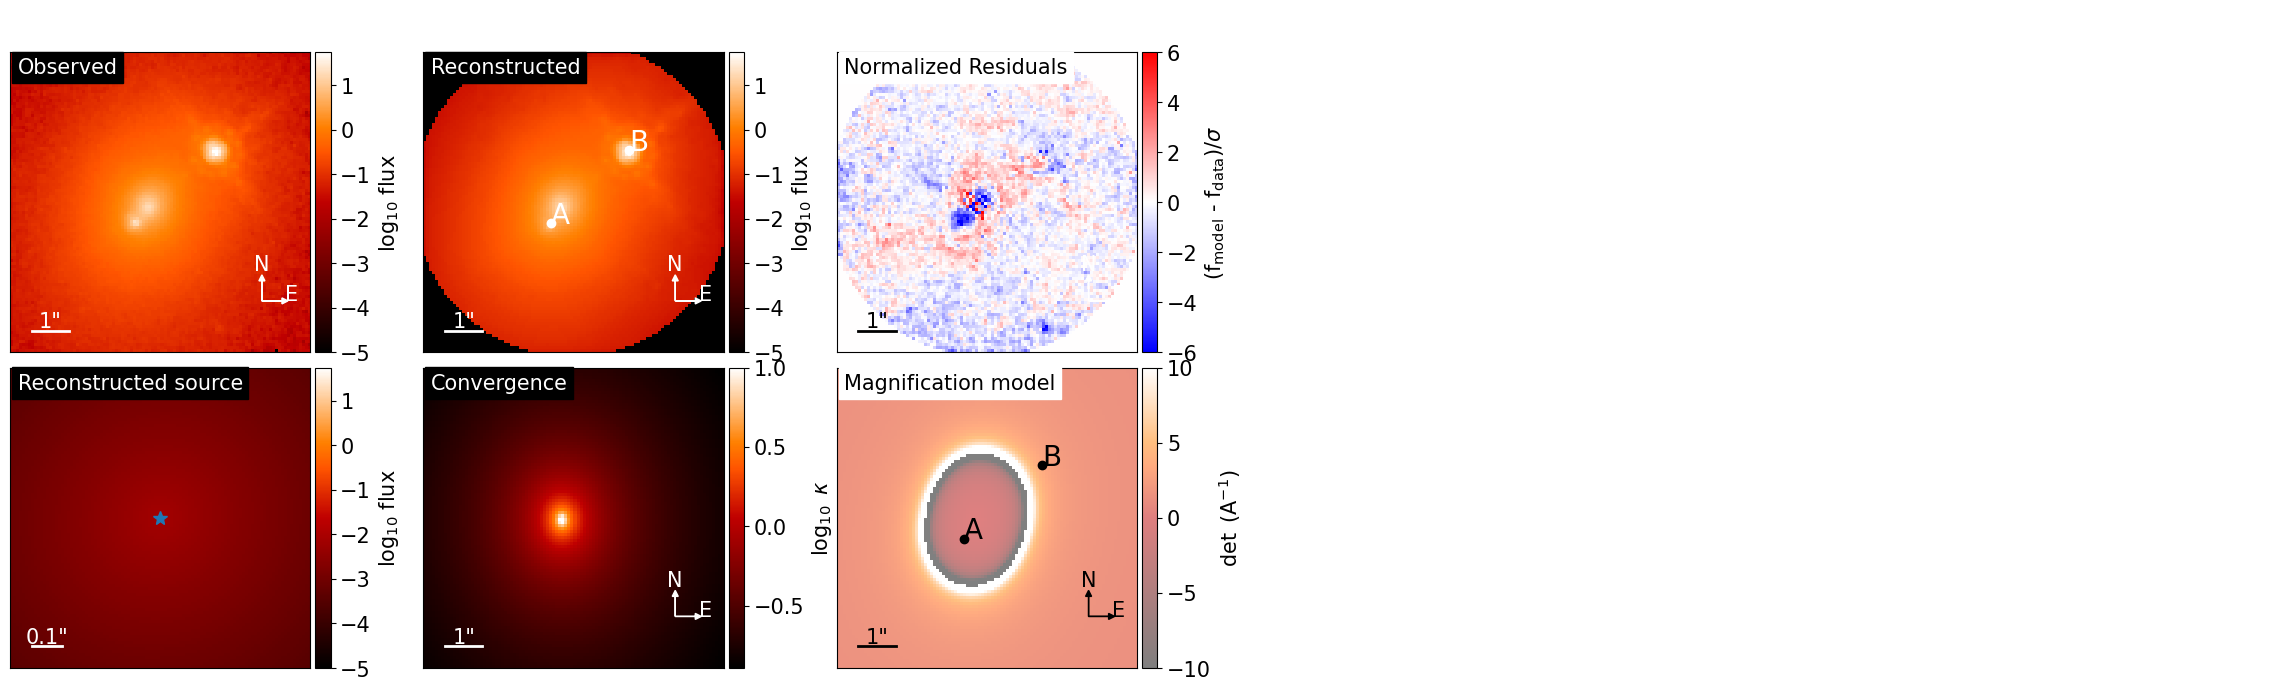

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1111: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


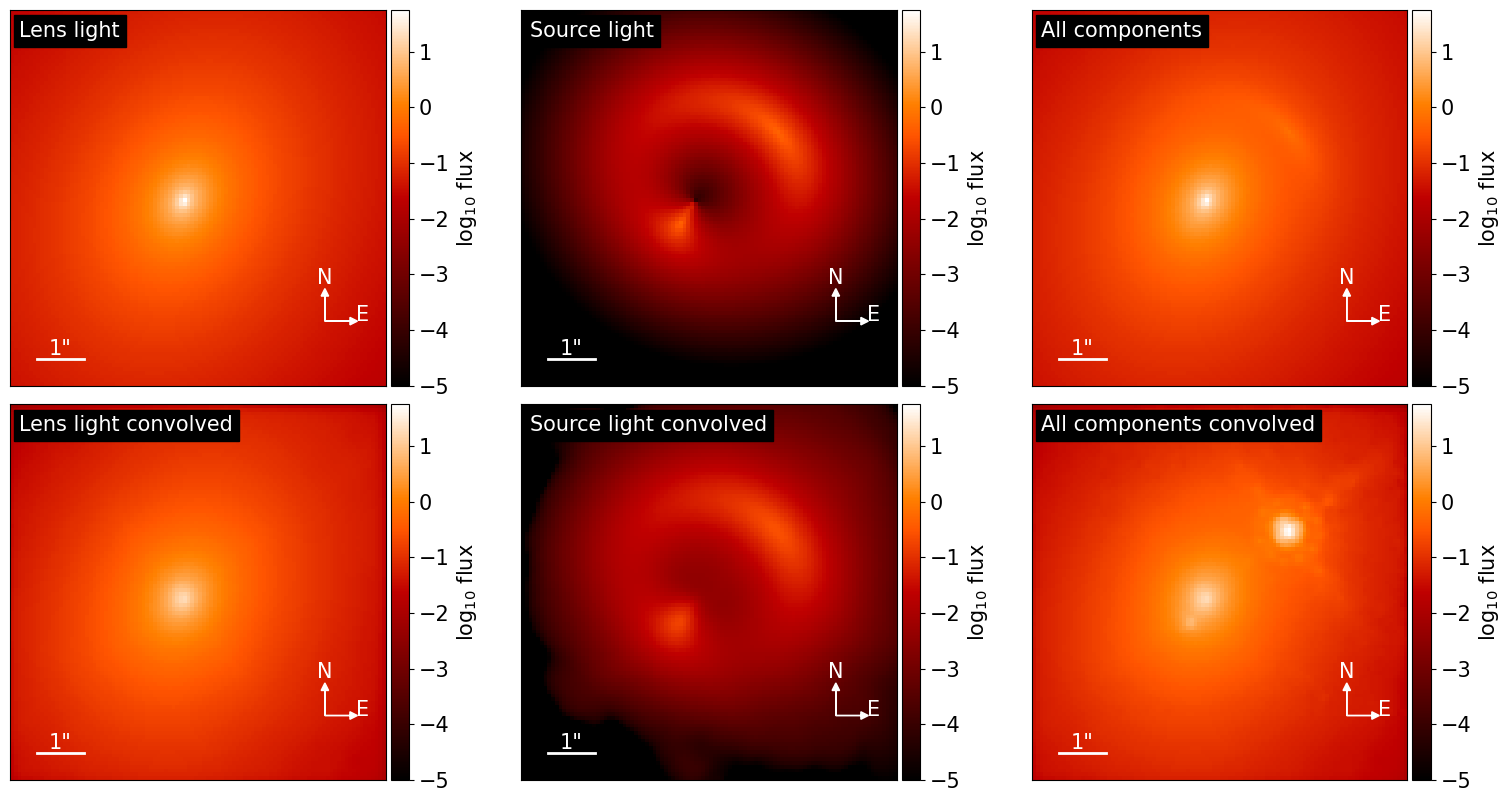

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1168: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data - model),


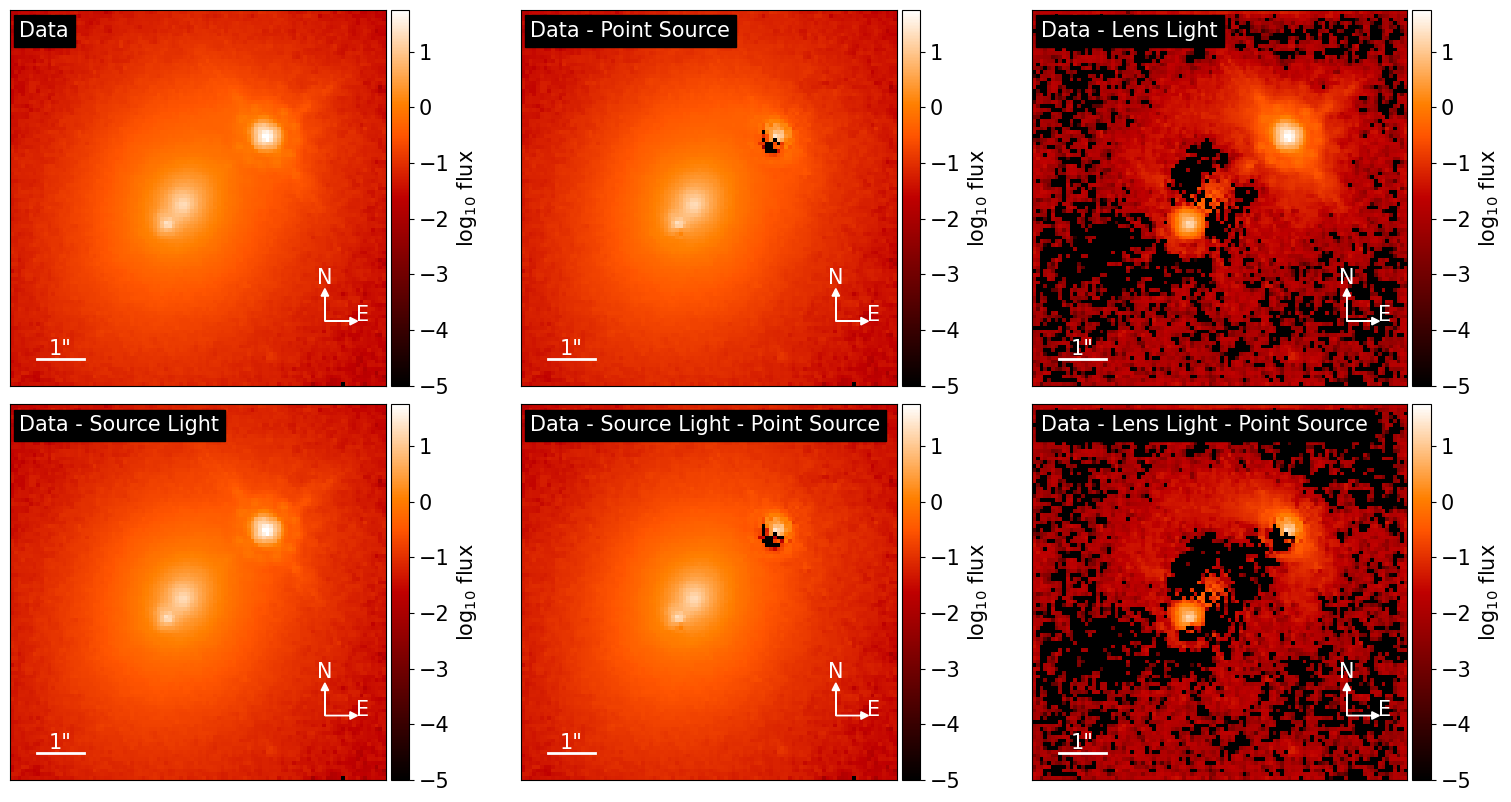

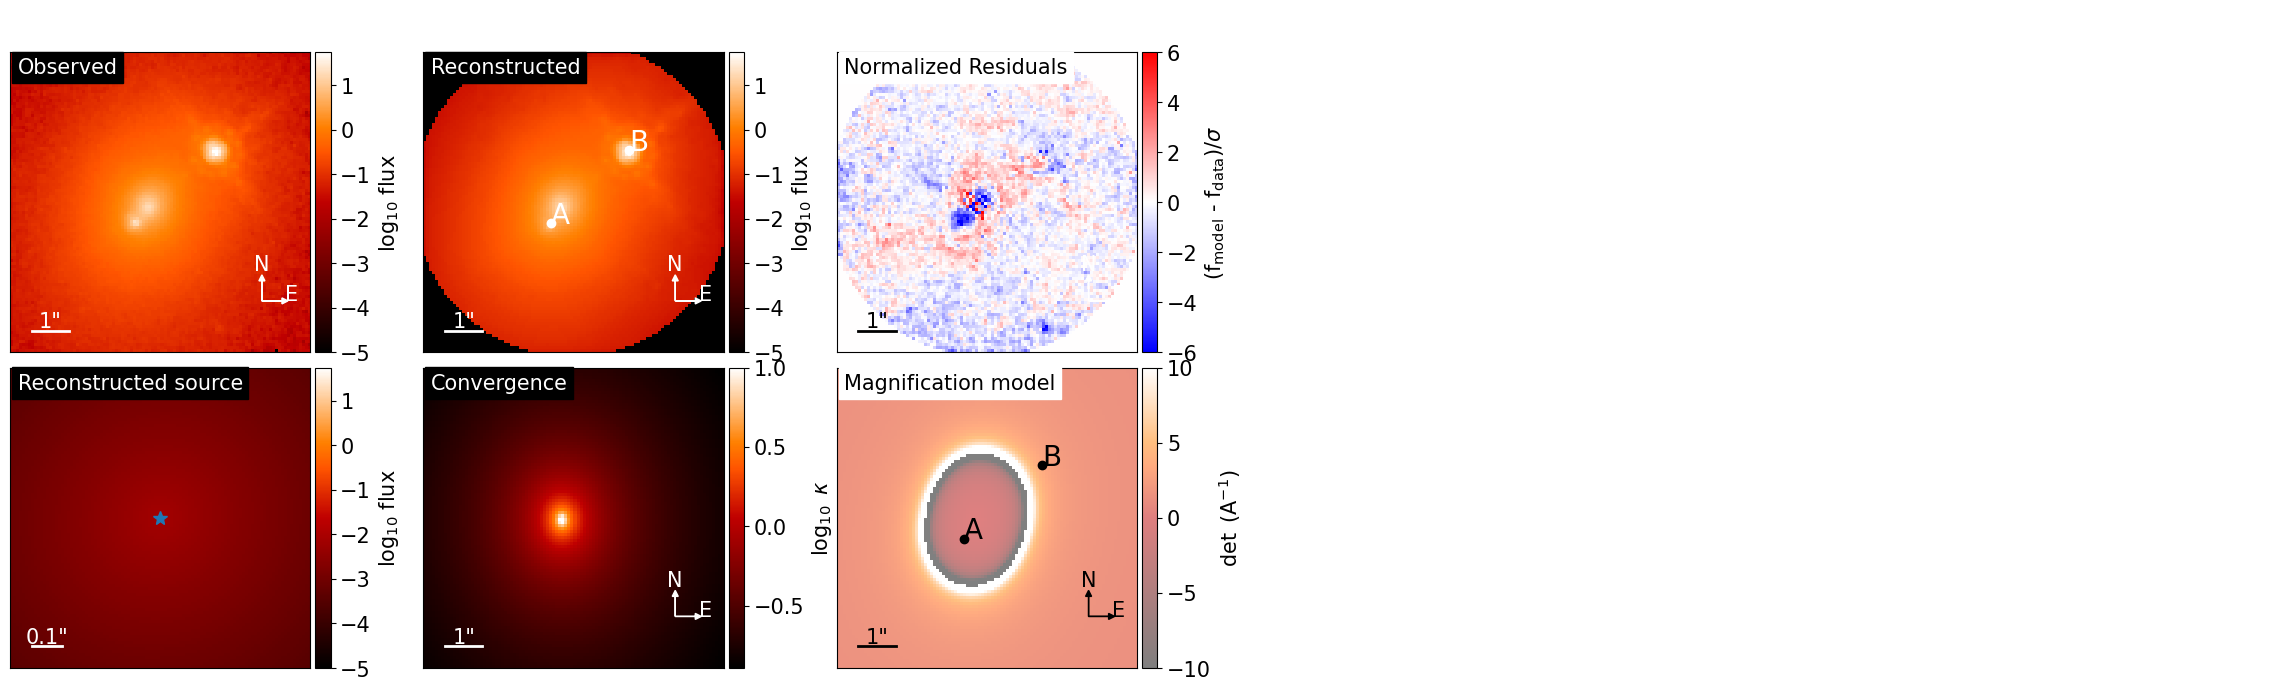

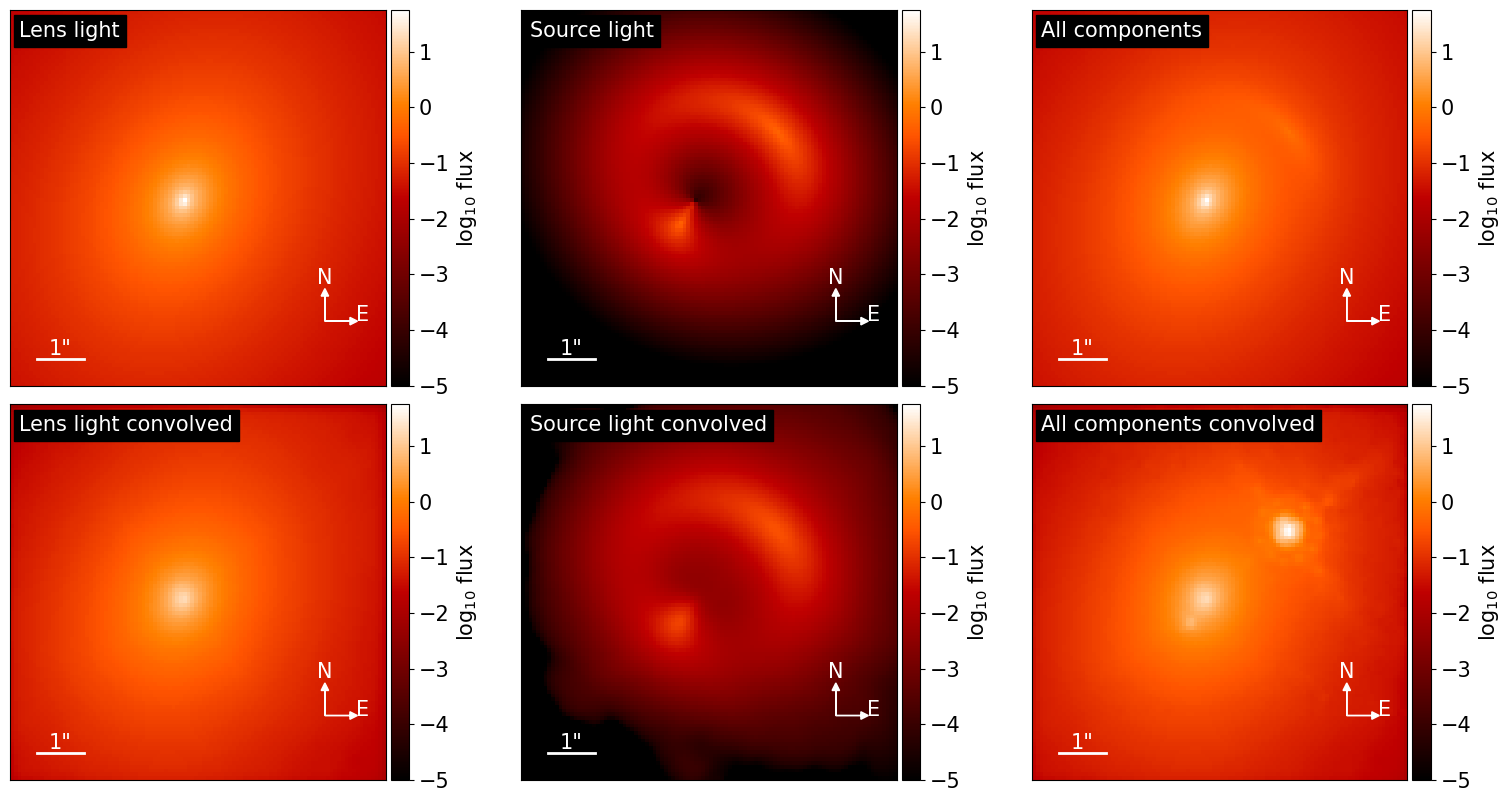

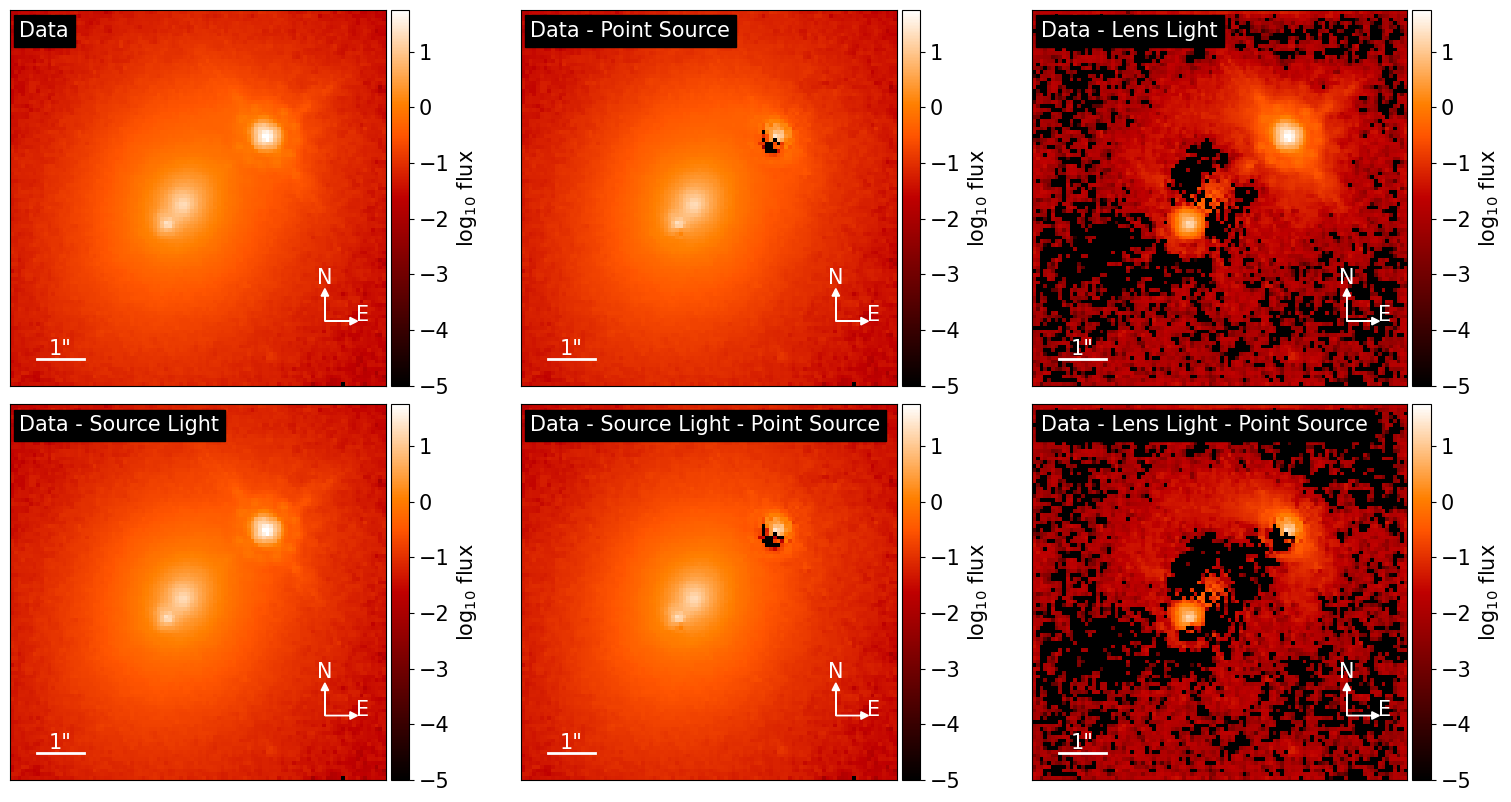

In [20]:
# add source light model arguments and update
# initial guesses to be results of previous run
kwargs_model.update({'source_light_model_list': source_model_list})
kwargs_model.update({'index_source_light_model_list': index_source_light_model_list})
kwargs_constraints.update({'joint_source_with_point_source': [[0, 0],
                                                              [0, 1],
                                                              [0, 2]]})
                           
lens_params = [kwargs_result['kwargs_lens'], kwargs_lens_sigma, [{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
lens_light_params = [kwargs_result['kwargs_lens_light'], kwargs_lens_light_sigma, [{}, {}, {}], kwargs_lower_lens_light, kwargs_upper_lens_light]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}, {}, {}], kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_result['kwargs_ps'], kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, verbose = True)

# try to fit the IR reference band as best we can before aligning images

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
multi_band_list = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
display(f)
f, axes = modelPlot.plot_separate()
display(f)
f, axes = modelPlot.plot_subtract_from_data_all()
display(f)


In [21]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

new_multiband = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]

iteration of step 0 gave best reconstruction.
log likelihood before: -4610.541802135093 and log likelihood after: -4610.541802135093


In [22]:
def align_images():
    
    fitting_kwargs_list = [
        ['align_images', {'n_particles': 50, 'n_iterations': 50, 
                      'align_offset': True, 'align_rotation': True, 
                      'delta_shift': .1, 'delta_rot': .1,
                      'compute_bands': [False, True, False]}],  # align second image
        ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, False]},  # now fit both bands jointly
                        }], 
        ['PSO', {'sigma_scale': 1., 'n_particles': 50, 'n_iterations': 100}],  # run PSO of both bands
        ]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    new_multiband = fitting_seq.multi_band_list

    return chain_list, kwargs_result, new_multiband

chain_list, kwargs_result, new_multiband = align_images()

Computing the Alignment fitting for band 1 ... ...


100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


Max iteration reached! Stopping.
Shifts found:  [0.2707161321061823, 0.017935104431265086, 0.012393282951531899]
66.43805193901062 time used for  Alignment fitting for band 1 ...
Align completed for band 1.
ra_shift: 0.2707161321061823,  dec_shift: 0.017935104431265086, phi_rot: 0.012393282951531899
Computing the PSO ...


100%|██████████| 100/100 [02:14<00:00,  1.35s/it]

Max iteration reached! Stopping.
-1.2386570860518 reduced X^2 of best position
-20095.35323556138 log likelihood
32447 effective number of data points
[{'theta_E': np.float64(1.5282291635125453), 'gamma': 2, 'e1': np.float64(-0.09740253578651326), 'e2': np.float64(0.0042697184767335), 'center_x': np.float64(7.661693363540536), 'center_y': np.float64(-0.1073164049712312)}, {'gamma1': np.float64(0.027185187198962478), 'gamma2': np.float64(-0.059583335023214265), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.375140834633448), 'n_sersic': np.float64(1.0984257286588286), 'e1': np.float64(-0.01206350916323886), 'e2': np.float64(0.02468682717517824), 'center_x': np.float64(8.006997381505126), 'center_y': np.float64(1.0487167119885066)}, {'amp': 1, 'R_sersic': np.float64(0.0032689631100128315), 'n_sersic': np.float64(1.025942481504838), 'e1': np.float64(-0.023042180683887643), 'e2': np.float64(-0.004307968120327251), 'center_x': np.float64(8.006997381505126), 'center

In [23]:
#now we run an iterative PSF reconstruction on both bands
kwargs_psf_iter.update({'compute_bands': [True, True, False]})

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

new_multiband = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]

iteration of step 0 gave best reconstruction.
log likelihood before: -5190.231310863229 and log likelihood after: -5190.231310863229
iteration of step 0 gave best reconstruction.
log likelihood before: -14904.83620842732 and log likelihood after: -14904.83620842732


-492.47172846722117 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0020241598607742
reduced chi^2 of data  1 =  0.8867730885110764
reduced chi^2 of data  2 =  1156.365275720236


/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:224: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


<Axes: >

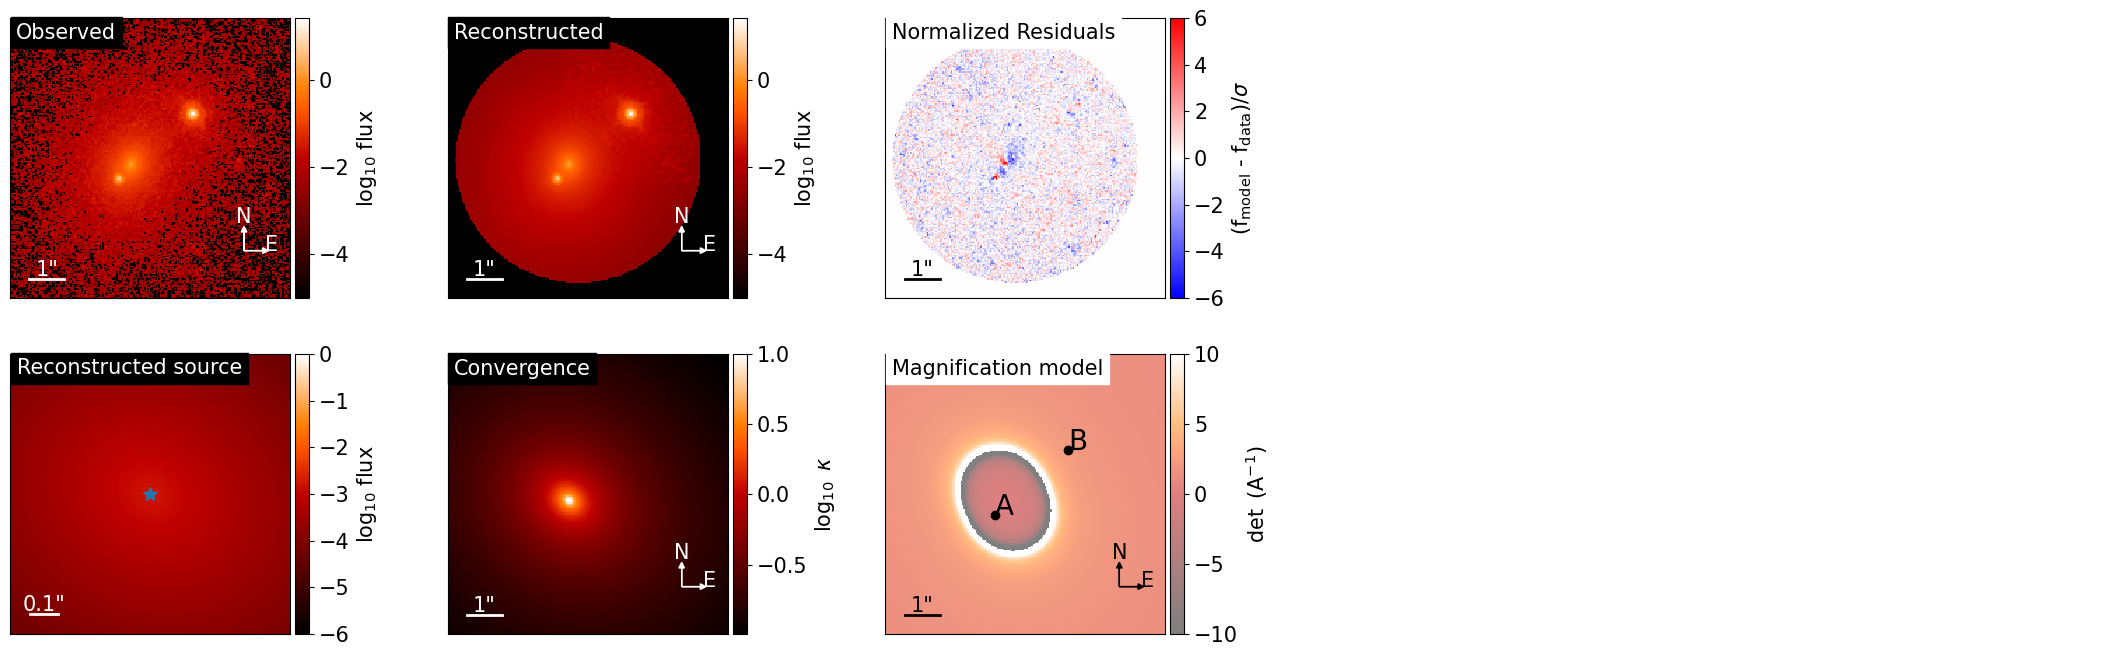

In [ ]:
modelPlot = ModelPlot(new_multiband, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0], band_index=1)
modelPlot.model_plot(ax=axes[0,1], band_index=1)
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6, band_index=1)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100,  v_min=-6, v_max=0, band_index=1)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1, band_index=1)
modelPlot.magnification_plot(ax=axes[1, 2], band_index=1)

-557.949598546102 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.2307876003944105
reduced chi^2 of data  1 =  1.2391782680767642
reduced chi^2 of data  2 =  1309.8448563497377


/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_9645/1741370598.py:19: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


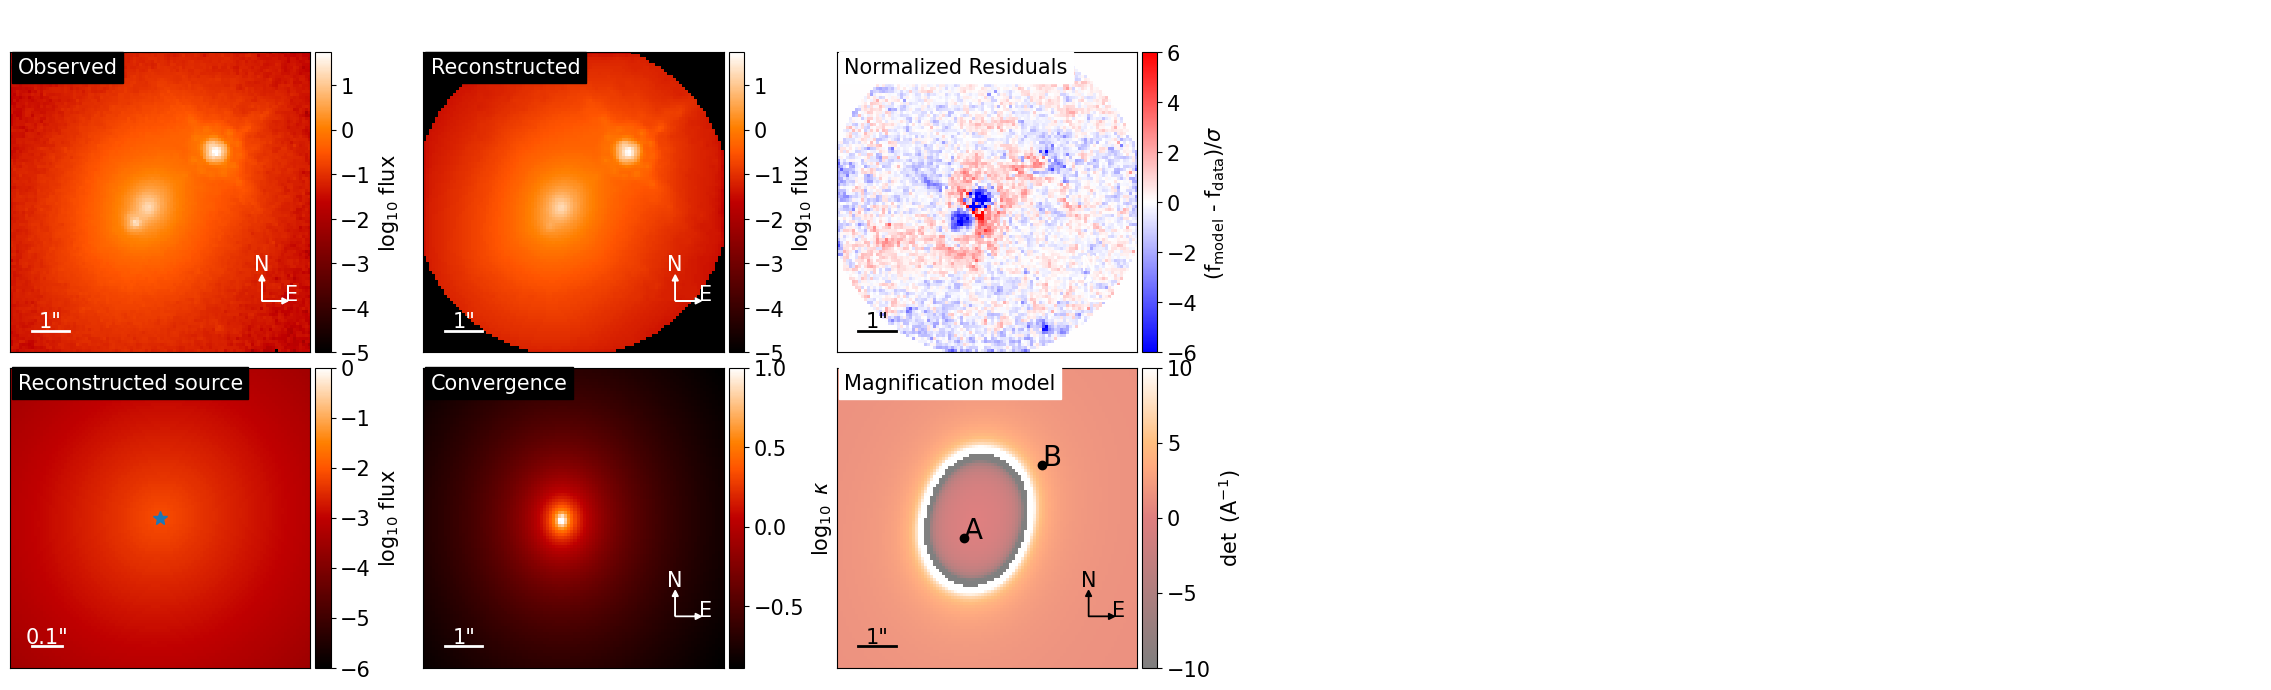

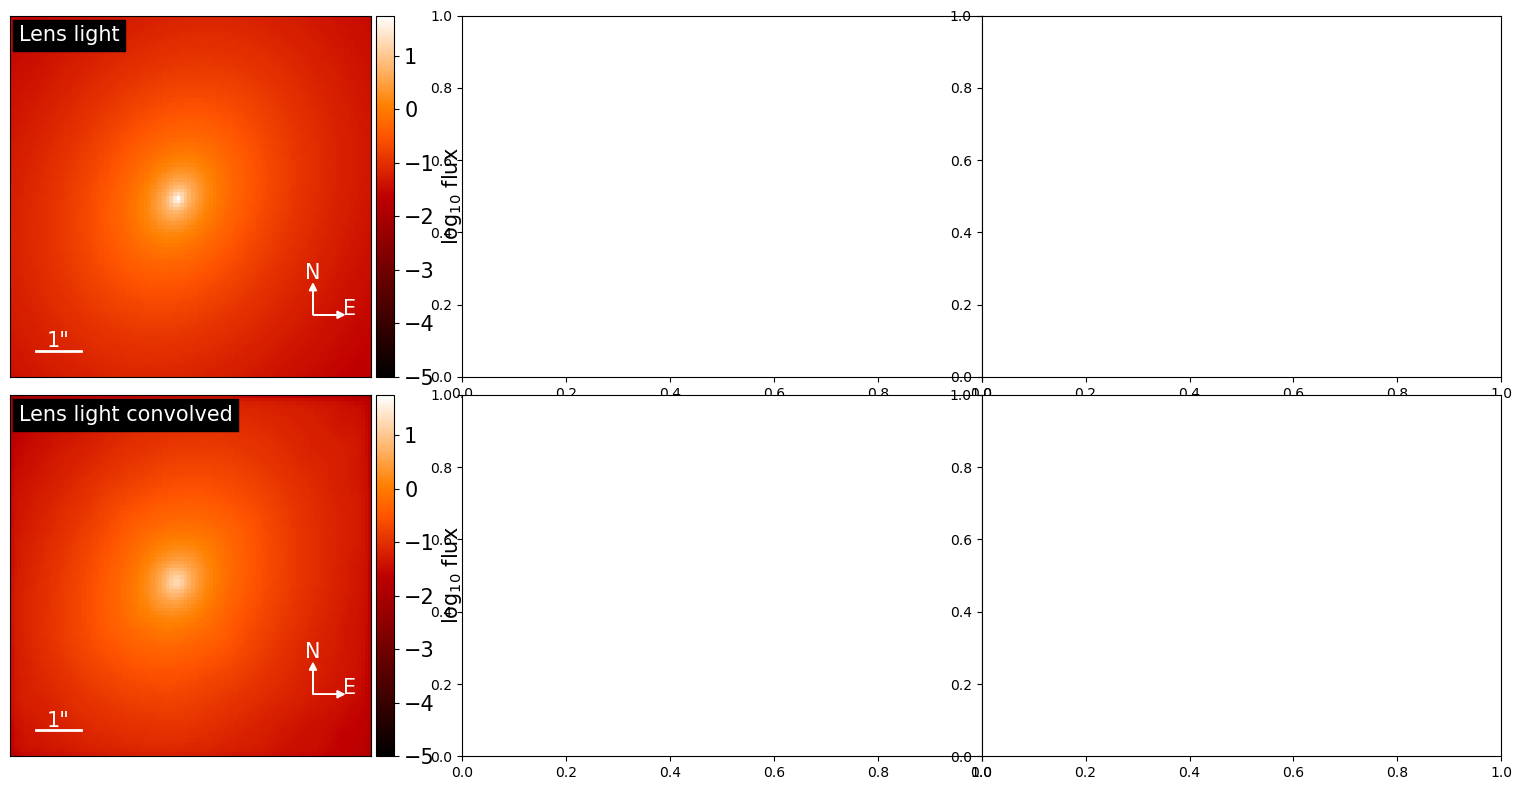

########################################################


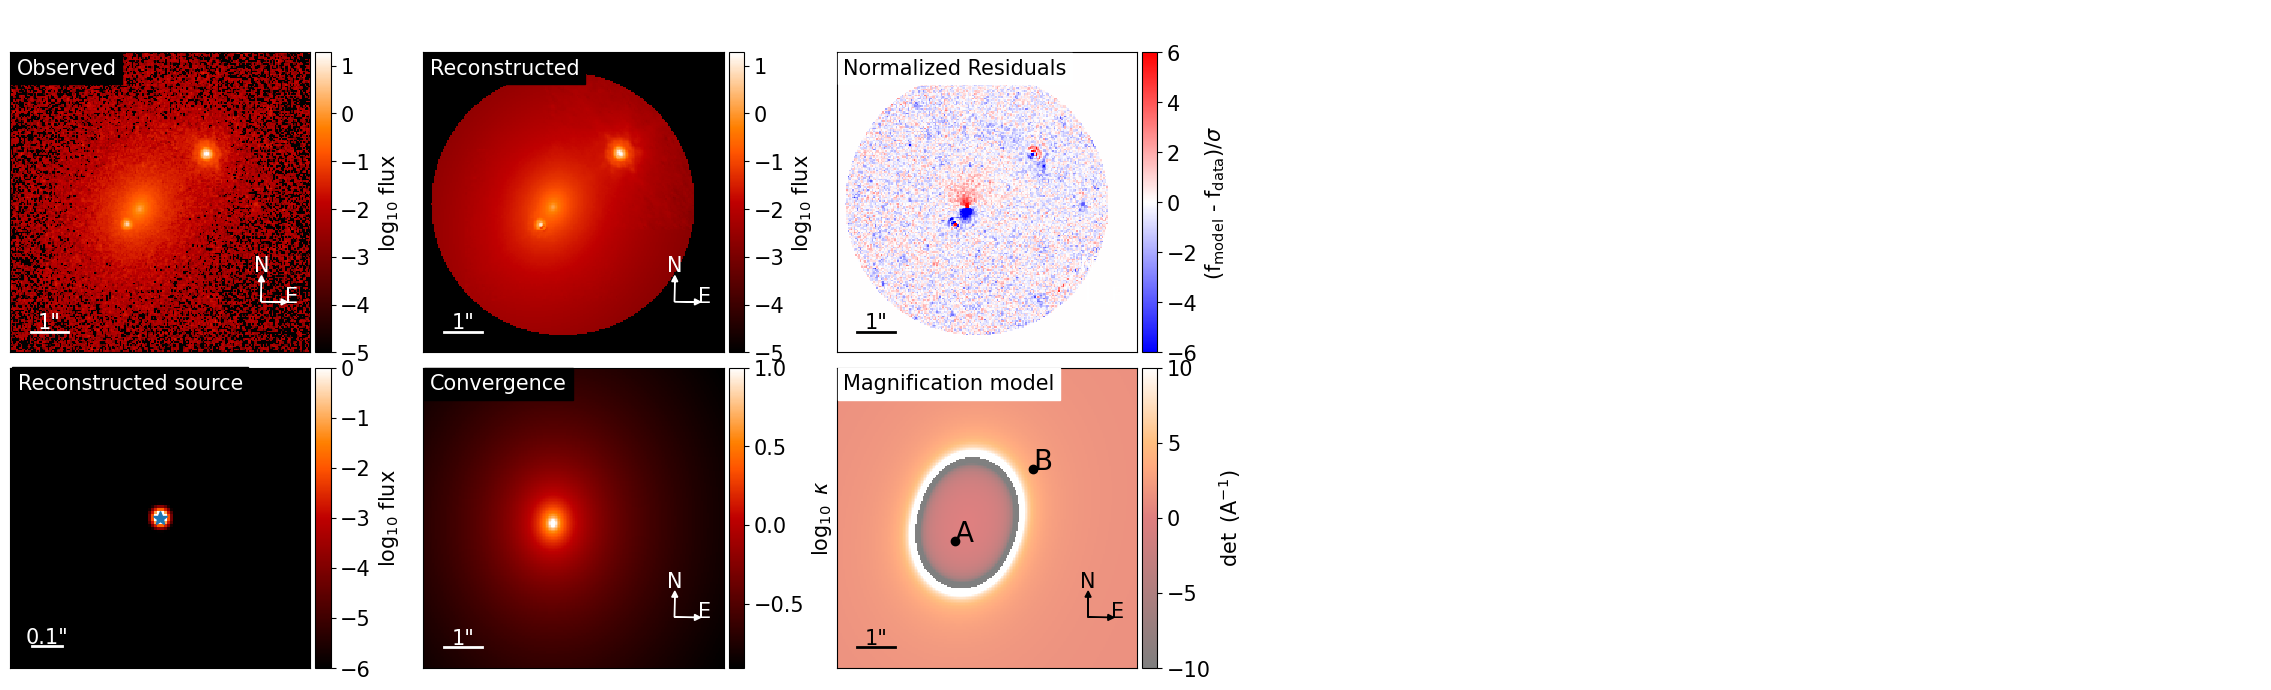

IndexError: list index out of range

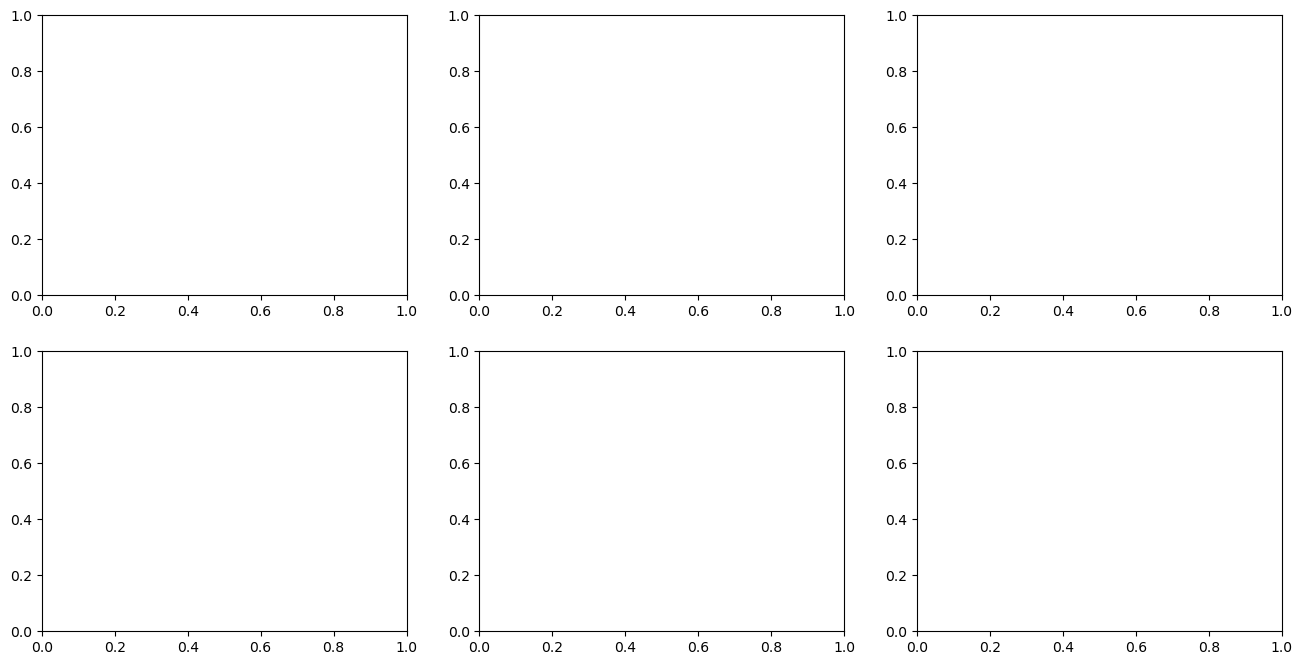

In [27]:
# we need to extract the updated multi_band_list object since the coordinate shifts were updated in the kwargs_data portions of it
multi_band_list_out = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")

def plot_band(modelPlot, band_index_plot):
    """
    a set of plotting routines for a ModelPlot() instance with specified band
    """

    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    modelPlot.data_plot(ax=axes[0,0], band_index=band_index_plot)
    modelPlot.model_plot(ax=axes[0,1], band_index=band_index_plot)
    modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6, band_index=band_index_plot)
    modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100,  v_min=-6, v_max=0, band_index=band_index_plot)
    modelPlot.convergence_plot(ax=axes[1, 1], v_max=1, band_index=band_index_plot)
    modelPlot.magnification_plot(ax=axes[1, 2], band_index=band_index_plot)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()

    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    modelPlot.decomposition_plot(ax=axes[0,0], band_index=band_index_plot, text='Lens light', lens_light_add=True, unconvolved=True)
    modelPlot.decomposition_plot(ax=axes[1,0], band_index=band_index_plot, text='Lens light convolved', lens_light_add=True)
    #modelPlot.decomposition_plot(ax=axes[0,1], band_index=band_index_plot, text='Source light', source_add=True, unconvolved=True)
    #modelPlot.decomposition_plot(ax=axes[1,1], band_index=band_index_plot, text='Source light convolved', source_add=True)
    #modelPlot.decomposition_plot(ax=axes[0,2], band_index=band_index_plot, text='All components', source_add=True, lens_light_add=True, unconvolved=True)
    #modelPlot.decomposition_plot(ax=axes[1,2], band_index=band_index_plot, text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    
plot_band(modelPlot, band_index_plot=0)
print('########################################################')
plot_band(modelPlot, band_index_plot=1)

In [ ]:
def align_images():
    
    fitting_kwargs_list = [
        ['align_images', {'n_particles': 100, 'n_iterations': 100, 
                      'align_offset': True, 'align_rotation': True, 
                      'delta_shift': 10., 'delta_rot': .5,
                      'compute_bands': [False, False, True]}],  # align second image
        ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, True]},  # now fit all bands jointly
                        }], 
        ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 250}],  # run PSO of all bands
        ]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    new_multiband = fitting_seq.multi_band_list

    return chain_list, kwargs_result, new_multiband

chain_list, kwargs_result, new_multiband = align_images()

In [ ]:
#now we run an iterative PSF reconstruction on all three bands
kwargs_psf_iter.update({'compute_bands': [True, True, True]})

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

new_multiband = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]

In [ ]:
# we need to extract the updated multi_band_list object since the coordinate shifts were updated in the kwargs_data portions of it
multi_band_list_out = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")
    
plot_band(modelPlot, band_index_plot=0)
print('########################################################')
plot_band(modelPlot, band_index_plot=1)
print('########################################################')
plot_band(modelPlot, band_index_plot=2)

In [ ]:
# run a final round of optimization + posterior sampling

fitting_kwargs_list = [
                       ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 500}],
                       ['psf_iteration', kwargs_psf_iter],
                       ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 500}],
                       ['MCMC', {'n_burn': 500, 'n_run': 1000, 'walkerRatio': 10,'sigma_scale': .1}]
]

with suppress_stdout_stderr(f"joint_modeling/{system_name}/{system_name}_joint_mcmc_chain.txt"):

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

kwargs_result = fitting_seq.best_fit()
multi_band_list_out = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")
    
plot_band(modelPlot, band_index_plot=0)
print('########################################################')
plot_band(modelPlot, band_index_plot=1)
print('########################################################')
plot_band(modelPlot, band_index_plot=2)

In [ ]:
# save the class data for later analysis
import pickle

save_dict = {
    "fitting_seq": fitting_seq,
    "kwargs_result": kwargs_result,
    "multi_band_list": multi_band_list,
    "kwargs_model": kwargs_model,
    "kwargs_params": kwargs_params,
    "chain_list": chain_list,
    "kwargs_constraints": kwargs_constraints,
    "kwargs_likelihood": kwargs_likelihood,
    "kwargs_data_joint": kwargs_data_joint
}

with open(f"joint_modeling/{system_name}/{system_name}_joint.pkl", "wb") as f:
    pickle.dump(save_dict, f)
